In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import wofz
import seaborn as sns
import scipy.optimize
import numpy as np
import astropy.units as u
from astropy.modeling.models import BlackBody


sns.set_style("darkgrid")

## Part 1

### Question 1

How does increasing or decreasing α in the Gaussian profile change the resulting Voigt profile? Which part of the Voigt profile does it most affect (line core or wings)? Plot a few 
representative figures/curves and refer to them in your answer. 

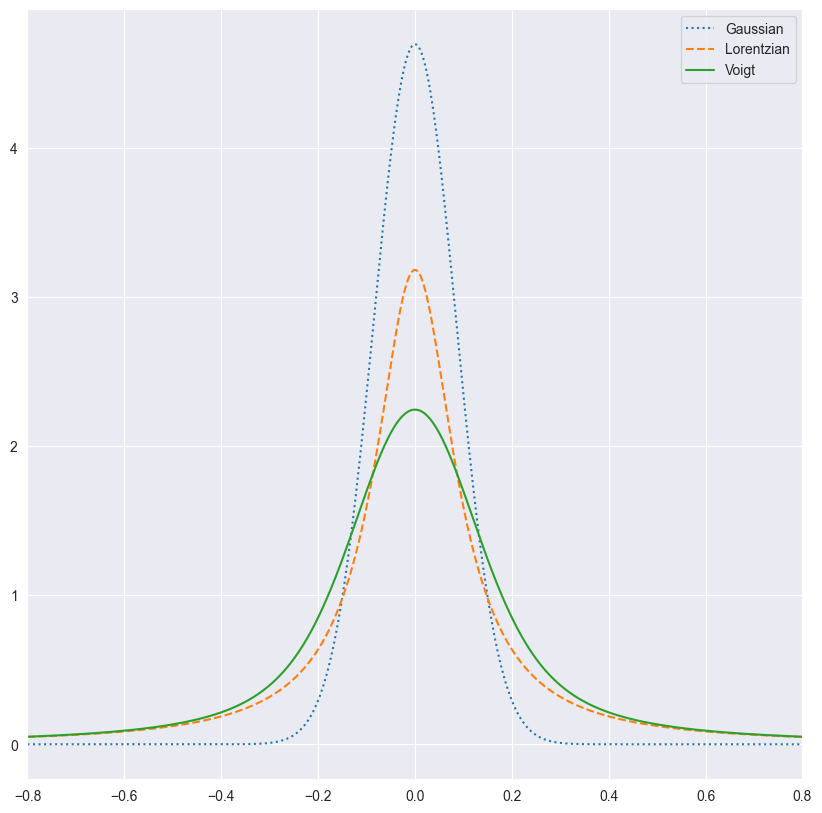

In [16]:
def gaussian_profile(x: np.ndarray, alpha: float) -> np.ndarray:
    """
    Calculate the Gaussian line profile.

    Parameters
    ----------
    x : np.ndarray
        The x values at which to evaluate the profile
    alpha : float
        The half width at half maximum (HWHM)

    Returns
    -------
    np.ndarray
        The Gaussian profile values
    """
    return np.sqrt(np.log(2) / np.pi) / alpha * np.exp(-((x / alpha) ** 2) * np.log(2))


def lorentzian_profile(x: np.ndarray, gamma: float) -> np.ndarray:
    """
    Calculate the Lorentzian line profile.

    Parameters
    ----------
    x : np.ndarray
        The x values at which to evaluate the profile
    gamma : float
        The half width at half maximum (HWHM)

    Returns
    -------
    np.ndarray
        The Lorentzian profile values
    """
    return gamma / (np.pi * (x**2 + gamma**2))


def voigt_profile(x: np.ndarray, alpha: float, gamma: float) -> np.ndarray:
    """
    Calculate the Voigt line profile, which is a convolution of Gaussian and Lorentzian profiles.

    Parameters
    ----------
    x : np.ndarray
        The x values at which to evaluate the profile
    alpha : float
        The Gaussian component HWHM
    gamma : float
        The Lorentzian component HWHM

    Returns
    -------
    np.ndarray
        The Voigt profile values
    """
    sigma = alpha / np.sqrt(2 * np.log(2))
    z = (x + 1j * gamma) / (sigma * np.sqrt(2))
    return np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi))


# Plot the three line profiles for comparison
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Define parameters
alpha = gamma = 0.1
x_values = np.linspace(-0.8, 0.8, 1000)

# Plot each profile
ax.plot(x_values, gaussian_profile(x_values, alpha), ls=":", label="Gaussian")
ax.plot(x_values, lorentzian_profile(x_values, gamma), ls="--", label="Lorentzian")
ax.plot(x_values, voigt_profile(x_values, alpha, gamma), label="Voigt")

# Set plot limits and add legend
ax.set_xlim(-0.8, 0.8)
ax.legend()

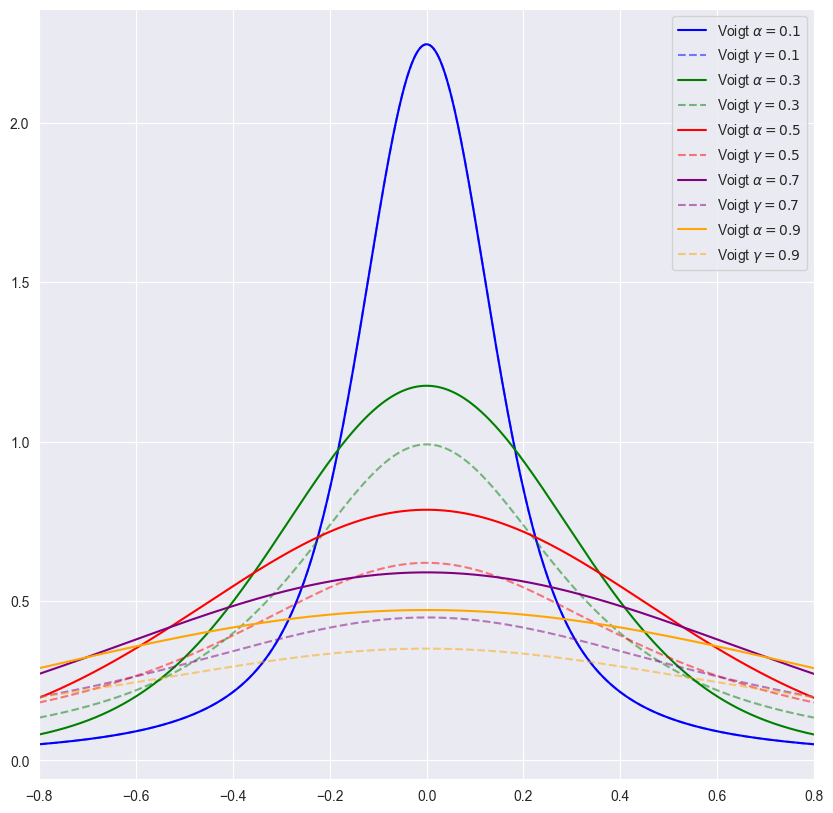

In [17]:
def plot_voigt_profiles(alpha_values, gamma, x_range=(-0.8, 0.8), num_points=1000):
    """
    Plot Voigt profiles for different alpha and gamma values.

    Parameters:
    -----------
    alpha_values : array-like
        Range of alpha values to plot
    gamma : float
        Fixed gamma value for comparison
    x_range : tuple
        (min, max) values for x-axis
    num_points : int
        Number of points to plot
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    x = np.linspace(x_range[0], x_range[1], num_points)
    colors = ["blue", "green", "red", "purple", "orange"]

    for i, alpha in enumerate(alpha_values):
        # Plot varying alpha with fixed gamma
        ax.plot(
            x,
            V(x, alpha, gamma),
            label=f"Voigt $\\alpha = {alpha:0.1}$",
            linestyle="-",
            color=colors[i],
        )

        # Plot varying gamma with fixed alpha
        ax.plot(
            x,
            V(x, gamma, alpha),
            label=f"Voigt $\\gamma = {alpha:0.1}$",
            linestyle="--",
            color=colors[i],
            alpha=0.5,
        )

    ax.set_xlim(x_range)
    ax.legend()


# Plot profiles with varying parameters
alpha_range = np.arange(0.1, 1, 0.2)
fixed_gamma = 0.1
plot_voigt_profiles(alpha_range, fixed_gamma)

From the curves above, changes in the Gaussian profile (α) cause the resulting Voigt profile to spread out and flatten for larger values. Increasing α changes the shape of the core more quickly than the shape of the wings. This can be seen by looking at the blue curves in the plot above: curves with different α values have relatively similar wing shapes but show greater differences in their core shapes. For example, the solid blue line (α = 0.1) has a taller, narrower core compared to the more spread out core of the solid purple line (α = 0.7).

### Question 2

How does increasing or decreasing γ  in the Lorentzian profile change the resulting Voigt profile?  Which part of the Voigt profile does it most affect (line core or wings)? 
Plot a few representative figures/curves and refer to them in your answer. 

Answer

- The curves above demonstrate how changes in the Lorentzian profile parameter γ affect the Voigt profile.
- Increasing γ not only reduces the height of the central peak (core) but also significantly broadens the wings of the profile. The effect on the wings is particularly pronounced - when comparing profiles with γ = 0.1 and γ = 0.3, we see a much more dramatic change in the wing shape than when making similar adjustments to α (the Gaussian width parameter). This indicates that the Lorentzian component γ has a stronger influence on the wings of the Voigt profile compared to the Gaussian component α.

### Question 3:
- The Voigt profile is created by convolving (combining) a Gaussian and a Lorentzian distribution. A convolution describes how one function's shape influences another function's shape. Mathematically, this process involves sliding one profile over the other and calculating the total overlapping area at each point. When both the Gaussian and Lorentzian components are centered at the same value, the maximum of the resulting Voigt profile will occur at that central value. This is because the overlap between the two distributions reaches its maximum when their peaks align.

## Part 2

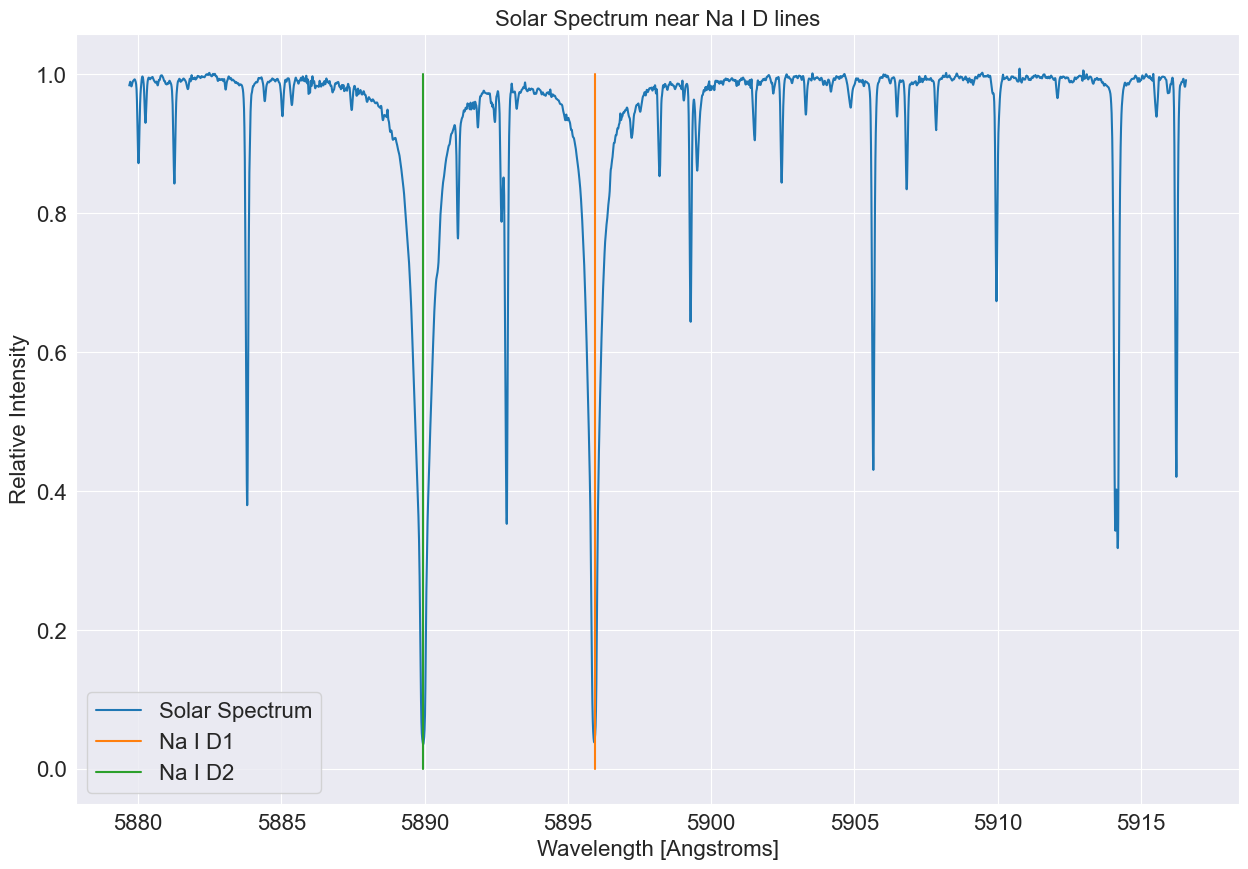

In [18]:
# Constants for Na D lines
NA_D1_WAVELENGTH = 5895.942
NA_D2_WAVELENGTH = 5889.950
FONT_SIZE = 16
FIGURE_SIZE = (15, 10)
Y_RANGE = [0, 1]


def load_spectrum_data(filepath):
    """Load wavelength and intensity data from file."""
    data = np.loadtxt(filepath)
    return data[:, 0], data[:, 1]


def convert_vacuum_to_air_wavelength(vacuum_wavelength):
    """Convert vacuum wavelength to air wavelength using standard formula."""
    return vacuum_wavelength * 0.99972683 + 0.0107 - (196.25 / vacuum_wavelength)


def create_na_d_lines():
    """Create arrays for plotting Na D lines."""
    na_d1 = np.repeat(NA_D1_WAVELENGTH, 2)
    na_d2 = np.repeat(NA_D2_WAVELENGTH, 2)
    return na_d1, na_d2


def plot_solar_spectrum(wavelength, intensity):
    """Create and configure plot of solar spectrum with Na D lines."""
    fig, ax = plt.subplots(1, 1, figsize=FIGURE_SIZE)
    plt.tick_params(labelsize=FONT_SIZE)

    # Plot main spectrum
    ax.plot(wavelength, intensity, label="Solar Spectrum")

    # Plot Na D lines
    na_d1, na_d2 = create_na_d_lines()
    ax.plot(na_d1, Y_RANGE, label="Na I D1")
    ax.plot(na_d2, Y_RANGE, label="Na I D2")

    # Configure plot aesthetics
    ax.legend(fontsize=FONT_SIZE)
    ax.set_xlabel("Wavelength [Angstroms]", fontsize=FONT_SIZE)
    ax.set_ylabel("Relative Intensity", fontsize=FONT_SIZE)
    ax.set_title("Solar Spectrum near Na I D lines", fontsize=FONT_SIZE)


# Main execution
vacuum_wavelength, intensity = load_spectrum_data("./data/hw3/nai_d_data.txt")
wavelength = convert_vacuum_to_air_wavelength(vacuum_wavelength)
plot_solar_spectrum(wavelength, intensity)

### Question 4

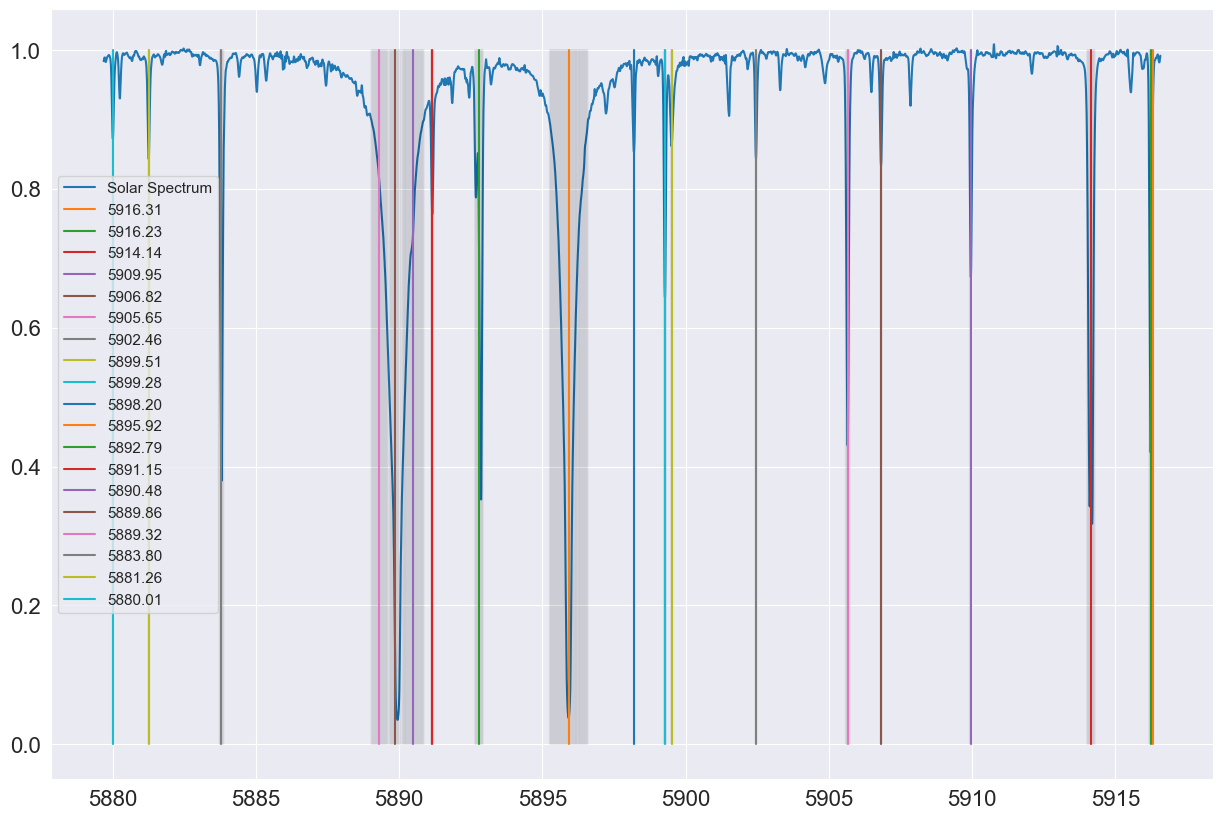

In [19]:
# Identify the wavelengths with intensity below some threshold
# Define constants
INTENSITY_THRESHOLD = 0.90
WAVELENGTH_GAP_THRESHOLD = 0.01
PLOT_ALPHA = 0.01
FONT_SIZE = 16
LEGEND_FONT_SIZE = 11
FIGURE_SIZE = (15, 10)
Y_RANGE = [0, 1]

# Find wavelengths below intensity threshold
low_intensity_mask = data[:, 1] < INTENSITY_THRESHOLD
filtered_wavelengths = wavelength[low_intensity_mask]

# Create plot
fig, ax = plt.subplots(1, 1, figsize=FIGURE_SIZE)
plt.tick_params(labelsize=FONT_SIZE)

# Plot solar spectrum
ax.plot(wavelength, intensity, label="Solar Spectrum")

# Plot vertical lines for all filtered wavelengths
for wave in filtered_wavelengths:
    ax.plot(np.repeat(wave, 2), Y_RANGE, alpha=PLOT_ALPHA, color='k')

# Find centers of absorption line groups
segment_ends = [0]
line_centers = []

for i in range(len(filtered_wavelengths)):
    wavelength_gap = abs(filtered_wavelengths[i] - filtered_wavelengths[i - 1])
    is_last_point = i == len(filtered_wavelengths) - 1
    
    if wavelength_gap > WAVELENGTH_GAP_THRESHOLD or is_last_point:
        # Calculate center index of current segment
        center_idx = segment_ends[-1] + (i - segment_ends[-1]) / 2
        segment_ends.append(i)
        line_centers.append(int(center_idx))

# Plot and label absorption line centers
for center_wavelength in filtered_wavelengths[line_centers]:
    center_line = np.repeat(center_wavelength, 2)
    ax.plot(center_line, Y_RANGE, label=f"{center_wavelength:.2f}")

ax.legend(fontsize=LEGEND_FONT_SIZE)

The program identifies spectral line centers based on an intensity threshold - lower thresholds reveal more lines. Comparing with the ASD catalog shows multiple Fe I lines (5880.01, 5881.27, 5883.81, 5891.17, 5892.69, 5905.67, 5906.84, 5909.97, 5914.11, 5914.20 Å), a Ti line at 5899.29 Å, and Th lines at 5899.51 and 5892.78 Å. Line center precision could be improved by analyzing smaller wavelength subsets.

Minimum intensities - D1: 0.038, D2: 0.035


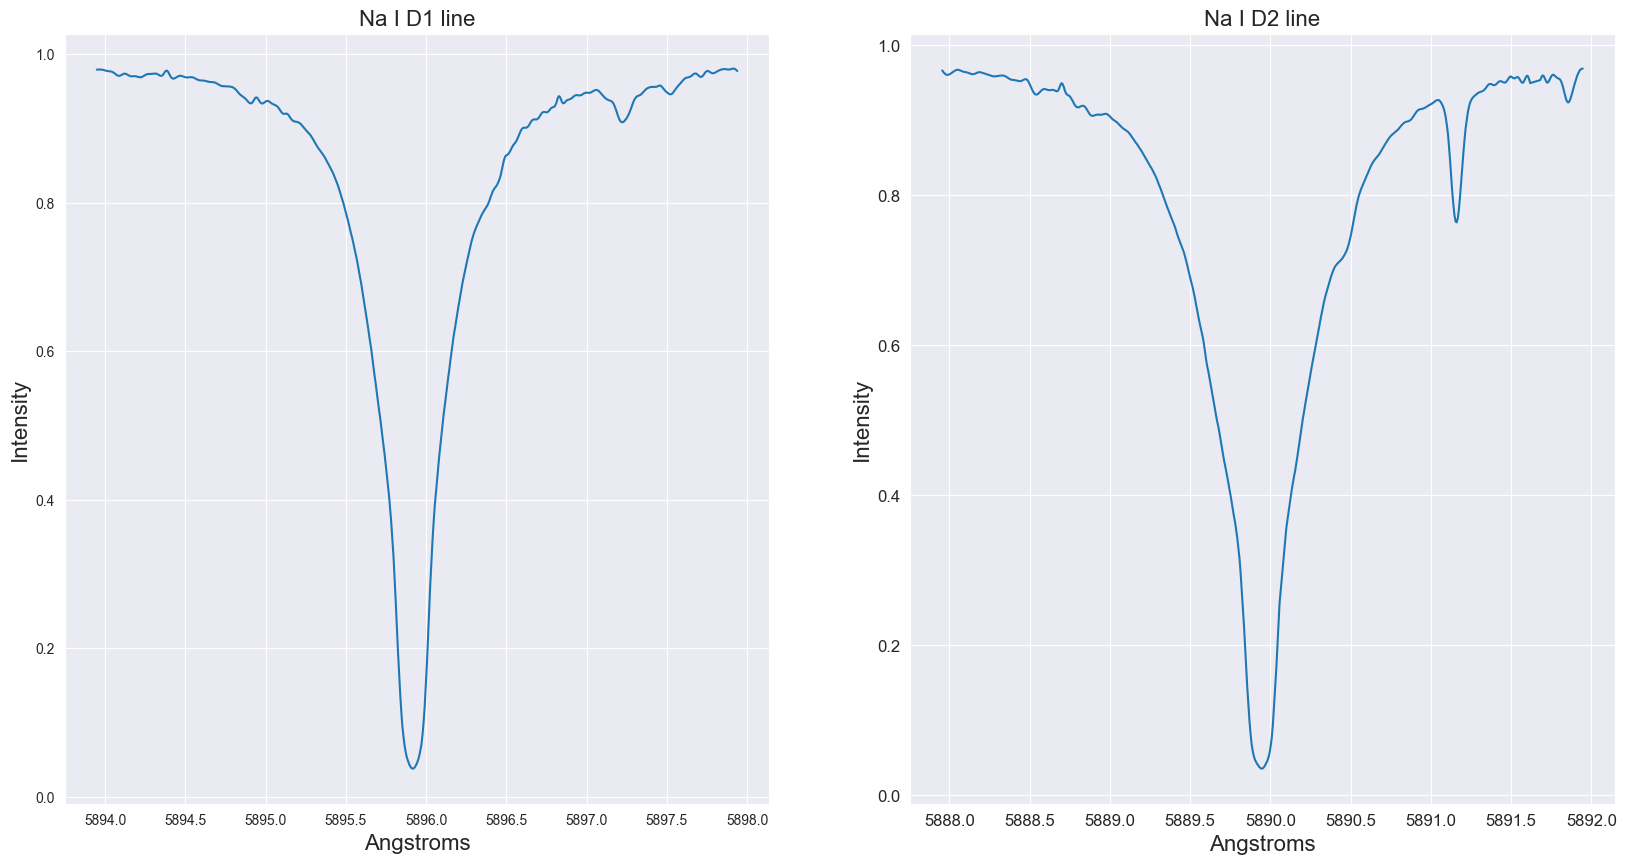

In [25]:
# Plot sodium D lines with ±2 Angstrom range around line centers
WINDOW_SIZE = 2  # Angstroms around each line center
FONT_SIZE_LABELS = 16
FONT_SIZE_TICKS = 12
FIGURE_SIZE = (20, 10)

# Create masks for wavelength ranges around each sodium line
d1_mask = abs(wavelength - na1d1[0]) < WINDOW_SIZE
d2_mask = abs(wavelength - na1d2[0]) < WINDOW_SIZE
subset = [d1_mask, d2_mask]

# Create figure with two subplots
fig, (d1_ax, d2_ax) = plt.subplots(1, 2, figsize=FIGURE_SIZE)
plt.tick_params(labelsize=FONT_SIZE_TICKS)

# Plot D1 line
d1_ax.plot(wavelength[d1_mask], intensity[d1_mask])
d1_ax.set_title('Na I D1 line', fontsize=FONT_SIZE_LABELS)
d1_ax.set_xlabel('Angstroms', fontsize=FONT_SIZE_LABELS)
d1_ax.set_ylabel('Intensity', fontsize=FONT_SIZE_LABELS)

# Plot D2 line
d2_ax.plot(wavelength[d2_mask], intensity[d2_mask])
d2_ax.set_title('Na I D2 line', fontsize=FONT_SIZE_LABELS)
d2_ax.set_xlabel('Angstroms', fontsize=FONT_SIZE_LABELS)
d2_ax.set_ylabel('Intensity', fontsize=FONT_SIZE_LABELS)

# Print minimum intensities for both lines
print(f"Minimum intensities - D1: {min(intensity[d1_mask]):.3f}, D2: {min(intensity[d2_mask]):.3f}")

### Question 5:

Both D1 and D2 lines show asymmetry with extended wings at longer wavelengths. D2 appears broader with a more prominent bulge, likely due to line blending. The lines have comparable depths.

In [26]:

def planck(lam, temp):
    bb = BlackBody(temp*u.K, scale=1*u.erg/u.s/u.cm**2/u.sr/u.cm)
    return bb(lam*u.cm).value

def one_layer_I(i0, tau, B):
    return i0*np.exp(-tau) + B*(1 - np.exp(-tau))


def two_layer_I(i0, tau_l, Bl, tau_s, Bs):
    i1 = i0*np.exp(-tau_l) + Bl*(1 - np.exp(-tau_l))
    return i1*np.exp(-tau_s) + Bs*(1 - np.exp(-tau_s))

/Users/bowanglan/Dev/astr-421/.venv/lib/python3.9/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Best-fit atmospheric temperature: 8.4 K


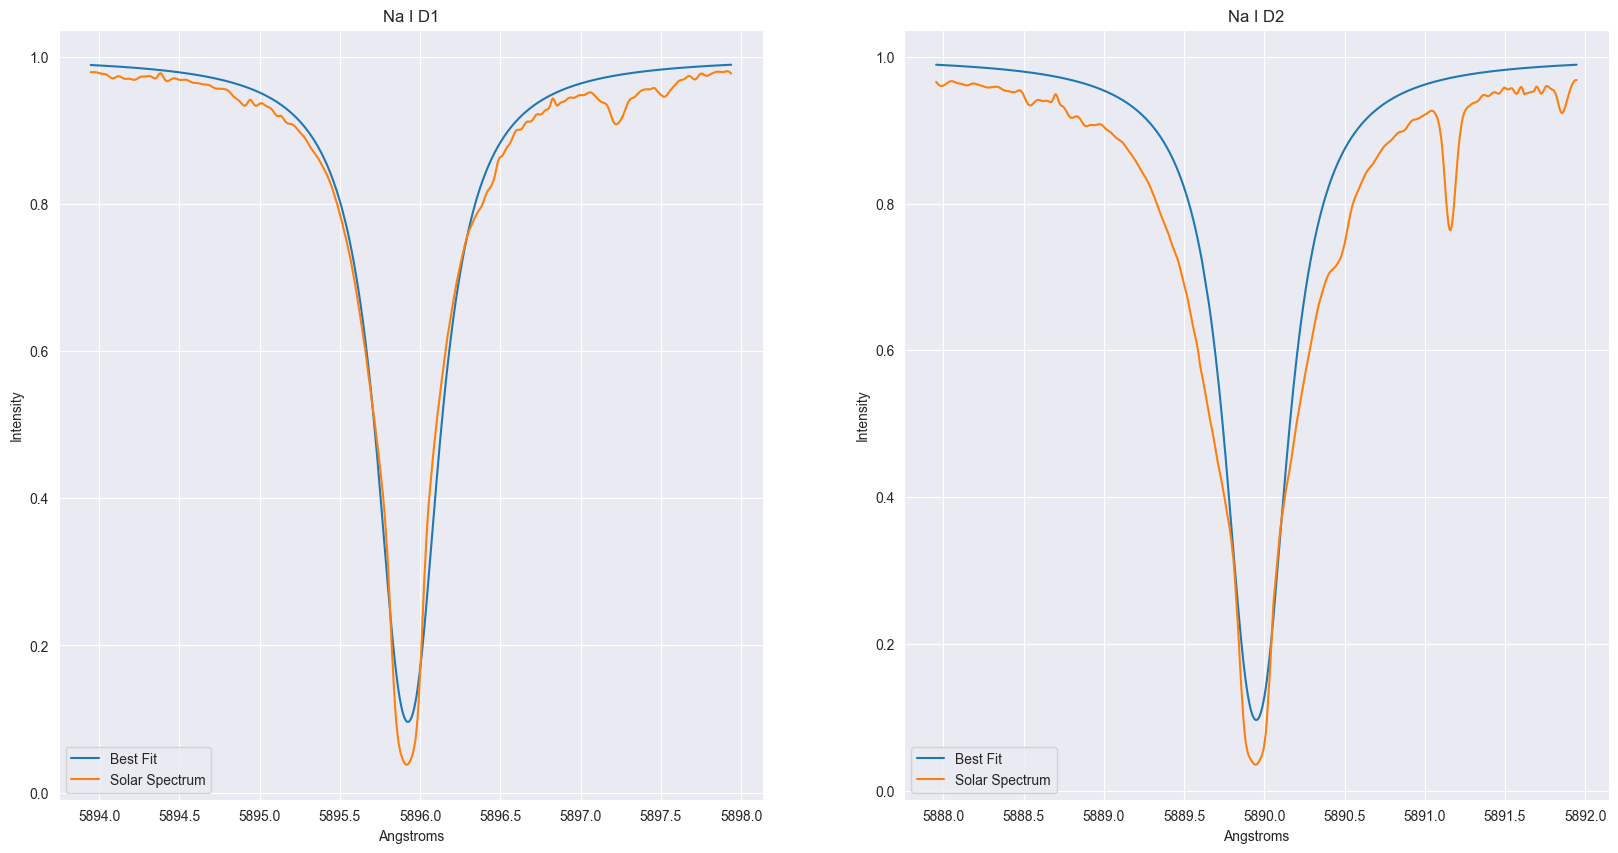

In [27]:
def calculate_normalized_intensity(wavelength, line_center, alpha, gamma, temperature):
    """
    Calculate normalized intensity using a one-layer atmospheric model with Voigt profile.

    Parameters
    ----------
    wavelength : array-like
        Wavelengths in Angstroms
    line_center : float
        Central wavelength of spectral line in Angstroms
    alpha : float
        Damping parameter for Voigt profile
    gamma : float
        Width parameter for Voigt profile
    temperature : float
        Temperature of atmospheric layer in Kelvin

    Returns
    -------
    float
        Normalized intensity relative to surface continuum
    """
    SURFACE_TEMP = 5770  # Solar surface temperature in Kelvin

    # Calculate optical depth using Voigt profile
    tau = V(wavelength - line_center, alpha, gamma)

    # Convert wavelength to cm for Planck function
    wavelength_cm = wavelength * 1e-8

    # Calculate source function and incident intensity
    incident_intensity = planck(wavelength_cm, SURFACE_TEMP)
    source_function = planck(wavelength_cm, temperature)

    # Calculate emergent intensity normalized by incident intensity
    return one_layer_I(incident_intensity, tau, source_function) / incident_intensity


# Fit model parameters to Na D1 line data
fit_bounds = ([5890, 0, 0, 0], [6000, 1, 1, 10000])
fit_params = scipy.optimize.curve_fit(
    calculate_normalized_intensity,
    wavelength[d1_mask],
    intensity[d1_mask],
    bounds=fit_bounds,
)[0]

# Plot fitted profiles for both Na D lines
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
line_labels = ["Na I D1", "Na I D2"]
line_centers = [5895.924, 5889.950]

for i, (ax, label, center) in enumerate(zip(axes, line_labels, line_centers)):
    # Plot model fit
    model_intensity = calculate_normalized_intensity(
        wavelength[subset[i]], center, fit_params[1], fit_params[2], fit_params[3]
    )
    ax.plot(wavelength[subset[i]], model_intensity, label="Best Fit")

    # Plot observed spectrum
    ax.plot(wavelength[subset[i]], intensity[subset[i]], label="Solar Spectrum")

    ax.legend()
    ax.set_title(label, fontsize=12)
    ax.set_xlabel("Angstroms", fontsize=10)
    ax.set_ylabel("Intensity", fontsize=10)

print(f"Best-fit atmospheric temperature: {fit_params[3]:.1f} K")

### Question 6
The model generally captures the overall shape of both sodium lines, though it fails to match their depths. While the wing shape fits well for Na I D1, it overestimates intensities for Na I D2. The model performs better at fitting the wings than the core depths.

### Question 7
The fit is better for Na I D1 than Na I D2 since the least-squares fitting was done using Na I D1 data. However, both fits are imperfect - they don't match line depths and overestimate wing intensities.

### Question 8
Temperature showed the largest adjustment while gamma showed the least, suggesting Na I D1 lines form far above the solar surface. The best-fit temperature of ~8 K, while unrealistic, demonstrates that the surrounding gas is much cooler than the surface. The deep Voigt profile parameters indicate very optically thick conditions where these lines form.

## Part 4

/var/folders/fb/xb26b7pj5_933srbq0z1j63w0000gp/T/ipykernel_79455/97805861.py:11: RuntimeWarning: overflow encountered in exp
  return i1*np.exp(-tau_s) + Bs*(1 - np.exp(-tau_s))
/var/folders/fb/xb26b7pj5_933srbq0z1j63w0000gp/T/ipykernel_79455/97805861.py:11: RuntimeWarning: invalid value encountered in multiply
  return i1*np.exp(-tau_s) + Bs*(1 - np.exp(-tau_s))


Fitted temperatures: T1 = 20.4K, T2 = 20.4K


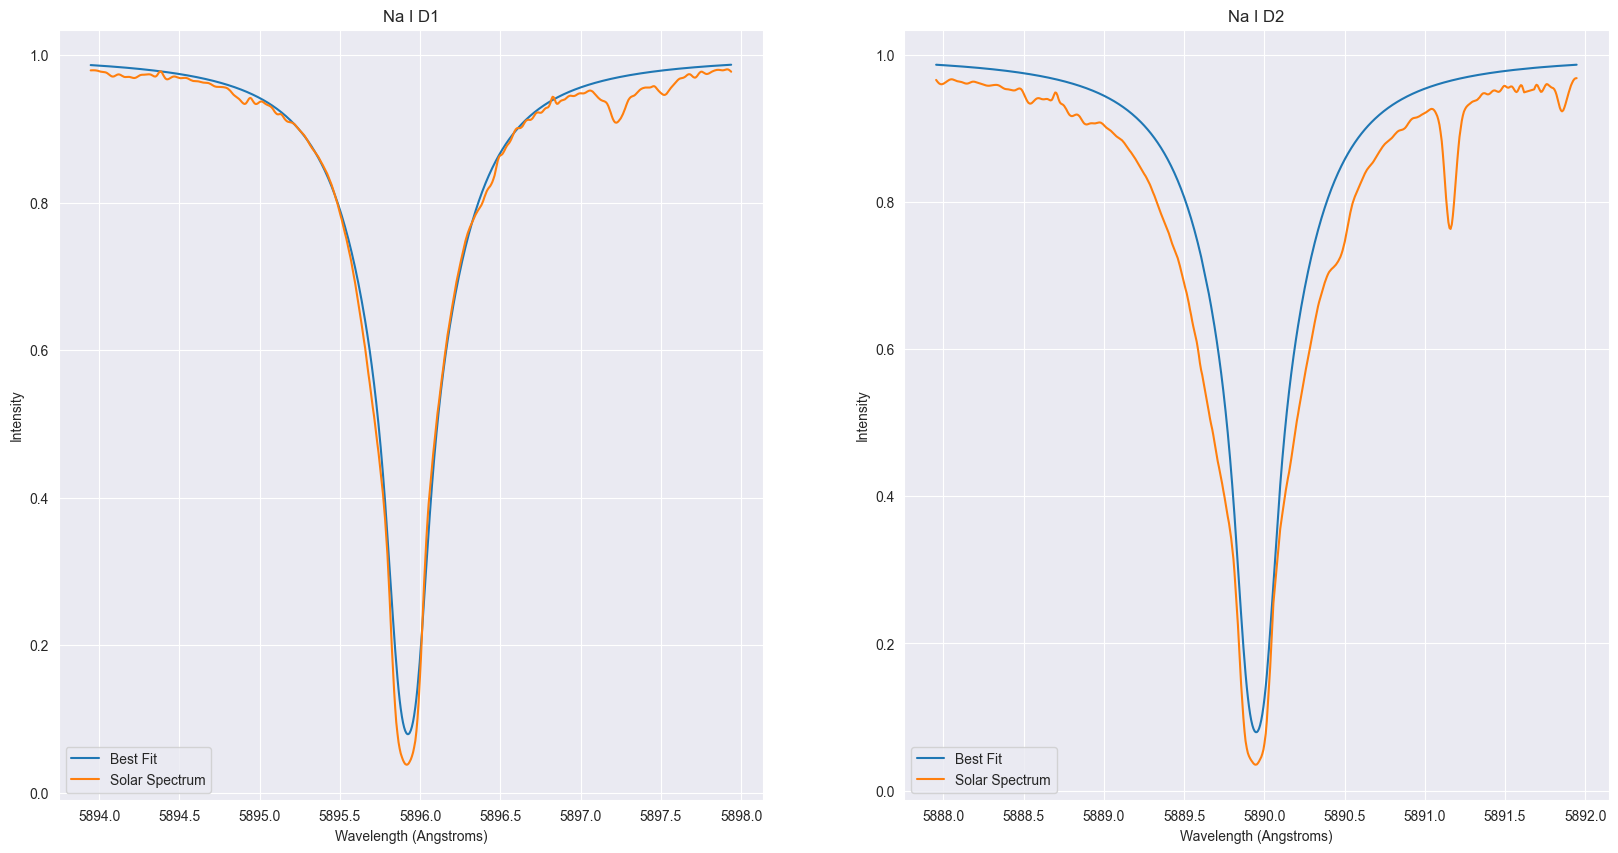

In [23]:
def two_layer_model(wavelength, line_center, alpha_1, gamma_1, alpha_2, gamma_2, temp_1, temp_2):
    """
    Calculate normalized intensity using a two-layer atmospheric model.
    
    Parameters
    ----------
    wavelength : float
        Wavelength in Angstroms
    line_center : float 
        Central wavelength of spectral line in Angstroms
    alpha_1, gamma_1 : float
        Voigt profile parameters for first layer
    alpha_2, gamma_2 : float
        Voigt profile parameters for second layer
    temp_1 : float
        Temperature of first layer in Kelvin
    temp_2 : float
        Temperature of second layer in Kelvin
        
    Returns
    -------
    float
        Normalized intensity
    """
    SOLAR_SURFACE_TEMP = 5770  # Kelvin
    LAYER_SCALE = 0.5  # Scale factor for optical depth
    
    # Convert wavelength to cm for Planck function
    wavelength_cm = wavelength * 1e-8
    
    # Calculate source intensity from solar surface
    source_intensity = planck(wavelength_cm, SOLAR_SURFACE_TEMP)
    
    # Calculate optical depths for both layers
    tau_1 = V(wavelength - line_center, alpha_1, gamma_1) * LAYER_SCALE
    tau_2 = V(wavelength - line_center, alpha_2, gamma_2) * LAYER_SCALE
    
    # Calculate source functions (Planck functions) for both layers
    source_1 = planck(wavelength_cm, temp_1)
    source_2 = planck(wavelength_cm, temp_2)
    
    # Calculate and normalize total intensity
    return two_layer_I(source_intensity, tau_1, source_1, tau_2, source_2) / source_intensity

# Define parameter bounds for optimization
param_bounds = (
    [5890, -10, -10, -10, -10, 0, 0],  # Lower bounds
    [6000, 10.1, 10.1, 10.1, 10.1, 10000, 10000]  # Upper bounds
)

# Fit the model parameters
fitted_params, _ = scipy.optimize.curve_fit(
    two_layer_model,
    wavelength[subset[0]],
    intensity[subset[0]], 
    bounds=param_bounds
)

# Unpack fitted parameters
line_center, alpha_1, gamma_1, alpha_2, gamma_2, temp_1, temp_2 = fitted_params

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
line_names = ['Na I D1', 'Na I D2']
line_centers = [5895.924, 5889.950]

for i, (ax, name, center) in enumerate(zip(axes, line_names, line_centers)):
    # Plot model fit
    model_intensity = two_layer_model(
        wavelength[subset[i]], 
        center, 
        alpha_1, 
        gamma_1,
        alpha_2, 
        gamma_2, 
        temp_1, 
        temp_2
    )
    ax.plot(wavelength[subset[i]], model_intensity, label="Best Fit")
    
    # Plot observed spectrum
    ax.plot(wavelength[subset[i]], intensity[subset[i]], label="Solar Spectrum")
    
    # Customize plot
    ax.legend()
    ax.set_title(name, fontsize=12)
    ax.set_xlabel('Wavelength (Angstroms)', fontsize=10)
    ax.set_ylabel('Intensity', fontsize=10)

print(f'Fitted temperatures: T1 = {temp_1:.1f}K, T2 = {temp_2:.1f}K')

### Question 9:
The two-atmosphere model produces an excellent fit for the Na I D1 line, with particularly good agreement in the wings and a slight overestimation in the core. However, when applying the same parameters to the Na I D2 line, the fit is poorer - the model overestimates intensity across most wavelengths due to the line being wider.

### Question 10:
The model performs better for D1 because its parameters were optimized using that line's data before being applied to D2. While sodium abundance is constant across the spectrum, other factors cause D2's increased width, making the D1-optimized parameters less suitable. Though the D1 fit appears good, the identical temperatures returned for both atmospheres raises concerns about the model's handling of optical depth-temperature relationships.

### Question 12:
The model parameters describe optical depth and temperature in the transfer equation. The dramatic temperature drop from the incident blackbody to ~20K suggests these Na I D lines form in a much cooler atmospheric region.

### Question 13:
The two-layer model provides a more realistic representation than the single-layer version, better capturing both wing shapes and core depths across both lines.

### Question 14:
Stellar atmospheric models improve with increased physical complexity. This model could be enhanced by:
- Including more layers to represent temperature gradients
- Incorporating hydrostatic equilibrium equations
- Adding thermodynamic, statistical and quantum mechanical considerations
- Accounting for radiative and convective energy transport
- Using comprehensive opacity libraries

This exercise effectively demonstrates how even simple stellar models can reveal key characteristics like line formation height. While the derived temperatures may be unphysical, they still provide valuable insights. It highlights both the utility of the transfer equation in spectral line formation and the fact that significant spectral features originate beyond the sun's visible surface.